In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.layers import *
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [14]:
df = pd.read_csv("Resources/EURUSD_2022_01.csv")
df.head()

,Date,Time,Open,High,Low,Close,M
0,2022.01.03,0:02,1.13674,1.13674,1.13674,1.13674,1
1,2022.01.03,0:03,1.13663,1.13674,1.13663,1.13674,5
2,2022.01.03,0:04,1.13663,1.13687,1.13663,1.13687,3
3,2022.01.03,0:05,1.13674,1.13687,1.13674,1.13674,3
4,2022.01.03,0:06,1.13684,1.13684,1.13644,1.13644,5


In [18]:
df["Datetime"] = df['Date'] + "_" +df['Time']
df2["Datetime"] = df2['Date']+"_" +df2['Time']
df["Datetime"] = pd.to_datetime(df['Datetime'], format='%Y.%m.%d_%H:%M')
df = df.drop(['Date','Time'],1)
# Rename bid OHLC columns
df.rename(columns={'Datetime': 'timestamp', 'Open': 'open', 'Close': 'close',
                   'High': 'high', 'Low': 'low', 'Close': 'close', 'M': 'volume'}, inplace=True)
df.index = df["timestamp"] +  pd.to_timedelta(2.5, unit='h')
df = df.astype(float)


# Add additional features
df['momentum'] = df['volume'] * (df['open'] - df['close'])
df['avg_price'] = (df['low'] + df['high']) / 2
# df['range'] = df['high'] - df['low']
df['ohlc_price'] = (df['low'] + df['high'] + df['open'] + df['close']) / 4
df['oc_diff'] = df['open'] - df['close']

print(df.head())

                        open     high      low    close  volume  momentum  \
timestamp                                                                   
2022-01-03 00:02:00  1.13674  1.13674  1.13674  1.13674     1.0   0.00000   
2022-01-03 00:03:00  1.13663  1.13674  1.13663  1.13674     5.0  -0.00055   
2022-01-03 00:04:00  1.13663  1.13687  1.13663  1.13687     3.0  -0.00072   
2022-01-03 00:05:00  1.13674  1.13687  1.13674  1.13674     3.0   0.00000   
2022-01-03 00:06:00  1.13684  1.13684  1.13644  1.13644     5.0   0.00200   

                     avg_price  ohlc_price  oc_diff  
timestamp                                            
2022-01-03 00:02:00   1.136740    1.136740  0.00000  
2022-01-03 00:03:00   1.136685    1.136685 -0.00011  
2022-01-03 00:04:00   1.136750    1.136750 -0.00024  
2022-01-03 00:05:00   1.136805    1.136772  0.00000  
2022-01-03 00:06:00   1.136640    1.136640  0.00040  


# Time series forecasting

In [221]:
# Data preparation for model training
def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# Create close_scaler to inverse it later
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler = close_scaler.fit(df[['close']])
closed = close_scaler.transform(df[['close']])

# Create open_scaler to inverse it later
open_scaler = MinMaxScaler(feature_range=(0, 1))
open_scaler = open_scaler.fit(df[['open']])
opened = open_scaler.transform(df[['open']])

X_close, y_close = create_dataset(closed, look_back=50)
X_open,y_open = create_dataset(opened, look_back=50)

train_size = int(len(X) * 0.99)

trainX1 = X_close[:train_size]
trainY1 = y_close[:train_size]
testX1 = X_close[train_size:]
testY1 = y_close[train_size:]

trainX2 = X_open[:train_size]
trainY2 = y_open[:train_size]
testX2 = X_open[train_size:]
testY2 = y_open[train_size:]

X_close.shape

(30095, 50, 1)

In [222]:
X_open.shape

(30095, 50, 1)

# Bidirectional LSTM model creation

In [126]:
# preparing model architecture for forecasting closing prices
model = Sequential()
model.add(
    Bidirectional(LSTM(30, input_shape=(trainX1.shape[1], trainX1.shape[2]),
                       return_sequences=True),
                  merge_mode='sum',
                  weights=None,
                  input_shape=(trainX1.shape[1], trainX1.shape[2])))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_14 (Bidirecti  (None, 50, 30)           7680      
 onal)                                                           
                                                                 
 lstm_43 (LSTM)              (None, 50, 10)            1640      
                                                                 
 dropout_14 (Dropout)        (None, 50, 10)            0         
                                                                 
 lstm_44 (LSTM)              (None, 4)                 240       
                                                                 
 dense_34 (Dense)            (None, 4)                 20        
                                                                 
 dense_35 (Dense)            (None, 1)                 5         
                                                     

In [127]:
# preparing model architecture for forecasting closing prices
model_open = Sequential()
model_open.add(
    Bidirectional(LSTM(30, input_shape=(trainX2.shape[1], trainX2.shape[2]),
                       return_sequences=True),
                  merge_mode='sum',
                  weights=None,
                  input_shape=(trainX2.shape[1], trainX2.shape[2])))
model_open.add(LSTM(10, return_sequences=True))
model_open.add(Dropout(0.2))
model_open.add(LSTM(4, return_sequences=False))
model_open.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model_open.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model_open.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model_open.summary())

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_15 (Bidirecti  (None, 50, 30)           7680      
 onal)                                                           
                                                                 
 lstm_46 (LSTM)              (None, 50, 10)            1640      
                                                                 
 dropout_15 (Dropout)        (None, 50, 10)            0         
                                                                 
 lstm_47 (LSTM)              (None, 4)                 240       
                                                                 
 dense_36 (Dense)            (None, 4)                 20        
                                                                 
 dense_37 (Dense)            (None, 1)                 5         
                                                     

In [128]:
# Training model and forecasting
model.fit(trainX1,trainY1,batch_size=64,epochs=4,validation_split=0.02)
model_open.fit(trainX2,trainY2,batch_size=64,epochs=4,validation_split=0.02)

Epoch 1/4
457/457 [==============================] - 37s 63ms/step - loss: 0.0673 - mae: 0.1629 - mse: 0.0673 - val_loss: 0.0017 - val_mae: 0.0319 - val_mse: 0.0017
Epoch 2/4
457/457 [==============================] - 23s 51ms/step - loss: 0.0011 - mae: 0.0260 - mse: 0.0011 - val_loss: 7.7621e-04 - val_mae: 0.0224 - val_mse: 7.7621e-04
Epoch 3/4
457/457 [==============================] - 21s 47ms/step - loss: 6.1765e-04 - mae: 0.0190 - mse: 6.1765e-04 - val_loss: 0.0011 - val_mae: 0.0252 - val_mse: 0.0011
Epoch 4/4
457/457 [==============================] - 22s 49ms/step - loss: 4.4284e-04 - mae: 0.0160 - mse: 4.4284e-04 - val_loss: 0.0017 - val_mae: 0.0327 - val_mse: 0.0017
Epoch 1/4
457/457 [==============================] - 28s 50ms/step - loss: 0.0804 - mae: 0.1953 - mse: 0.0804 - val_loss: 4.4634e-04 - val_mae: 0.0169 - val_mse: 4.4634e-04
Epoch 2/4
457/457 [==============================] - 27s 59ms/step - loss: 6.4300e-04 - mae: 0.0182 - mse: 6.4300e-04 - val_loss: 0.0011 - val_

In [129]:
pred_close = model.predict(testX1)
pred_close = np.reshape(close_scaler.inverse_transform(pred_close), (pred_close.shape[0]))
close = np.reshape(close_scaler.inverse_transform(testY1), (testY1.shape[0]))
predictions = pd.DataFrame()
predictions['predicted_close'] = pd.Series(pred_close)
predictions['close'] = pd.Series(close)

pred_open = model_open.predict(testX2)
pred_open = np.reshape(open_scaler.inverse_transform(pred_open), (pred_open.shape[0]))
openn = np.reshape(open_scaler.inverse_transform(testY2), (testY2.shape[0]))
predictions['predicted_open'] = pd.Series(pred_open)
predictions['open'] = pd.Series(openn)

p = df[-pred.shape[0]:].copy()
predictions.index = p.index
predictions = predictions.astype(float)
predictions = predictions.merge(p[['low', 'high']], right_index=True, left_index=True)
predictions.head()

10/10 [==============================] - 1s 10ms/step


,predicted_close,close,predicted_open,open,low,high
timestamp,,,,,,
2022-01-31 19:00:00,1.121077,1.12101,1.120994,1.12081,1.12103,1.12132
2022-01-31 19:01:00,1.121113,1.12127,1.121009,1.12103,1.12094,1.12128
2022-01-31 19:02:00,1.121154,1.12099,1.121037,1.12127,1.12100,1.12120
2022-01-31 19:03:00,1.121197,1.12119,1.121078,1.12100,1.12111,1.12120
2022-01-31 19:04:00,1.121243,1.12119,1.121104,1.12120,1.12118,1.12148


C:\Users\panka\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\panka\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


MSE :  1.3847649039994893e-07
MAPE :  0.00023993399208203404


count    301.000000
mean       0.000046
std        0.000370
min       -0.001055
25%       -0.000090
50%        0.000044
75%        0.000247
max        0.001122
Name: diff_close, dtype: float64

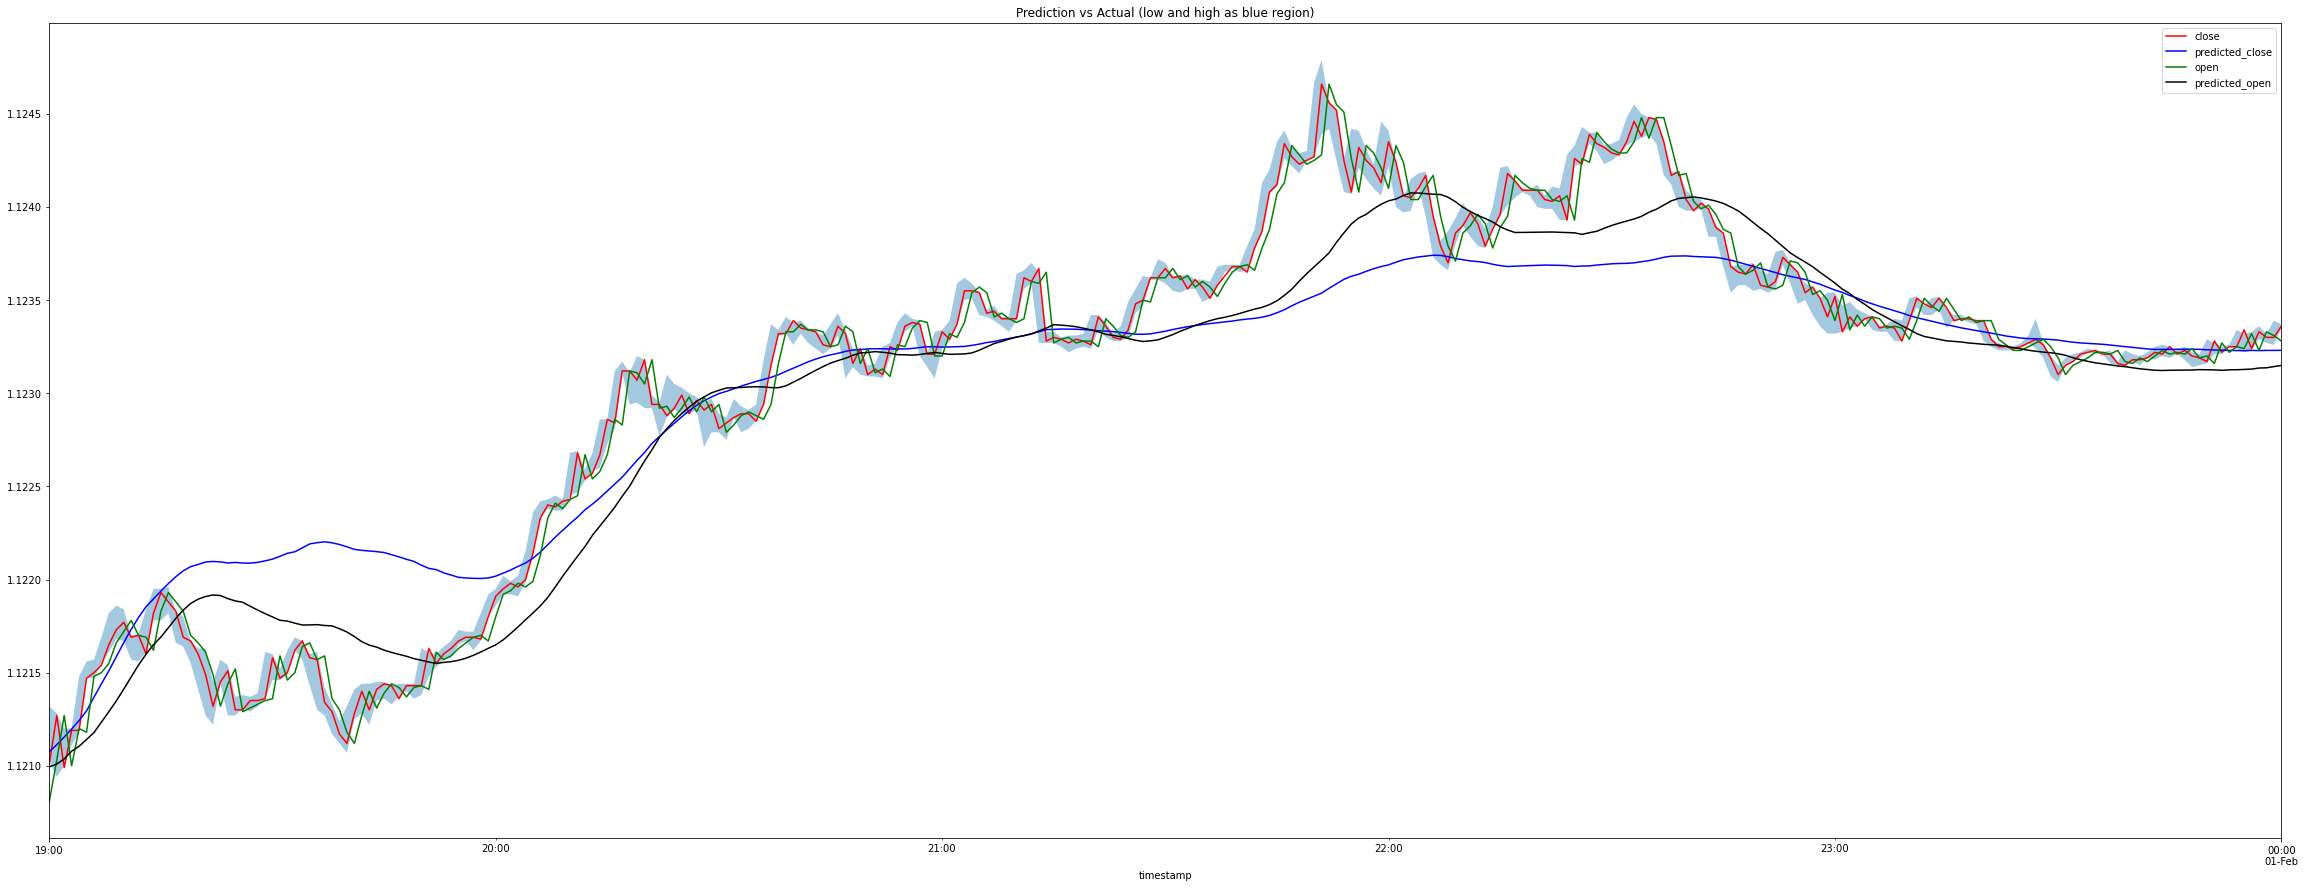

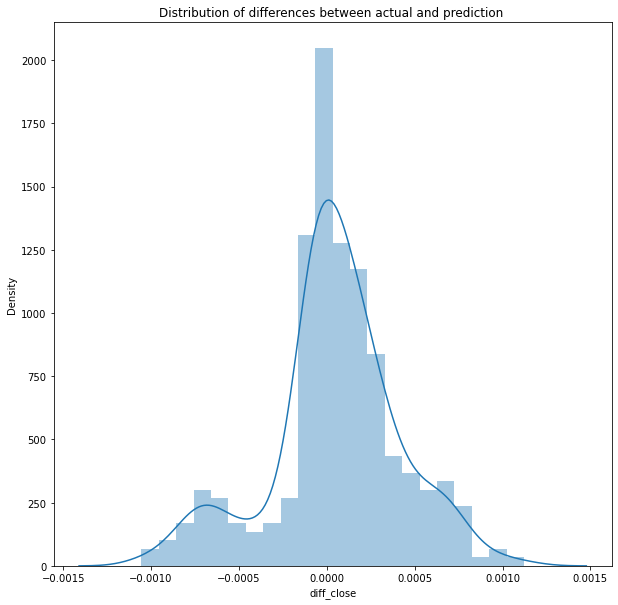

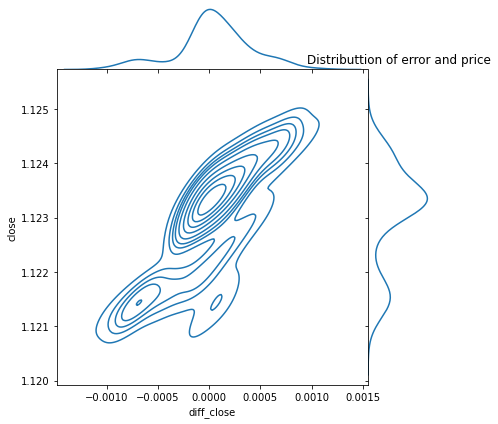

In [138]:
ax = predictions.plot(y="close",c="red",figsize=(40,15))
ax = predictions.plot(y="predicted_close", c="blue",ax=ax)
ax = predictions.plot(y="open",c="green",ax=ax)
ax = predictions.plot(y="predicted_open", c="black",ax=ax)
plt.fill_between(x=predictions.index, y1='low', y2='high', data=p, alpha=0.4)
plt.title('Prediction vs Actual (low and high as blue region)')

predictions['diff_close'] = predictions['close'] - predictions['predicted_close']
plt.figure(figsize=(10, 10))
sns.distplot(predictions['diff_close']);
plt.title('Distribution of differences between actual and prediction ')

g = sns.jointplot("diff_close", "close", data=predictions, kind="kde", space=0)
plt.title('Distributtion of error and price')

print("MSE : ", mean_squared_error(predictions['close'].values, predictions['predicted_close'].values))
print("MAPE : ", mean_absolute_percentage_error(predictions['close'].values, predictions['predicted_close'].values))
predictions['diff_close'].describe()

# MAPE of 0.02% and graphical visualisation indicates good prediction of forex trend to give signals accurately enough for trading
# Open, Close are predicted and represented in line plot below
# Range of High and low are depicted using light blue spreaded line
# Distribution on difference between predicted and actual closing price are depicted

In [202]:
df2 = pd.read_csv("Resources/Replaced_data.csv")
df2.head()

,Date,Time,Currency,Description,Actual,Forecast,Previous
0,2021.07.19,04:00,NZD,BusinessNZ Services Index,58.6,NaN,56.3
1,2021.07.19,04:31,GBP,Rightmove HPI m/m,0.007,NaN,0.008
2,2021.07.19,15:30,EUR,German Buba Monthly Report,NaN,NaN,NaN
3,2021.07.19,15:30,GBP,MPC Member Haskel Speaks,NaN,NaN,NaN
4,2021.07.19,19:30,USD,NAHB Housing Market Index,80,82,81


In [203]:
df2['Datetime'] = df2[['Date','Time']].apply(lambda x: str(x[0]) + "_" + str(x[1]))
df2.head()

,Date,Time,Currency,Description,Actual,Forecast,Previous,Datetime
0,2021.07.19,04:00,NZD,BusinessNZ Services Index,58.6,NaN,56.3,NaN
1,2021.07.19,04:31,GBP,Rightmove HPI m/m,0.007,NaN,0.008,NaN
2,2021.07.19,15:30,EUR,German Buba Monthly Report,NaN,NaN,NaN,NaN
3,2021.07.19,15:30,GBP,MPC Member Haskel Speaks,NaN,NaN,NaN,NaN
4,2021.07.19,19:30,USD,NAHB Housing Market Index,80,82,81,NaN


In [204]:
df2 = df2[df2["Currency"].isin(['EUR','USD'])]
df2.head()

,Date,Time,Currency,Description,Actual,Forecast,Previous,Datetime
2,2021.07.19,15:30,EUR,German Buba Monthly Report,NaN,NaN,NaN,NaN
4,2021.07.19,19:30,USD,NAHB Housing Market Index,80,82,81,NaN
5,2021.07.19,21:00,USD,President Biden Speaks,NaN,NaN,NaN,NaN
9,2021.07.20,11:30,EUR,German PPI m/m,0.013,0.013,0.015,NaN
10,2021.07.20,13:30,EUR,Current Account,11.7B,24.3B,22.1B,NaN


In [205]:
df2["Datetime"] = df2['Date']+"_" +df2['Time']
df2["timestamp"] = pd.to_datetime(df2['Datetime'], format='%Y.%m.%d_%H:%M')

In [206]:
df2.index = pd.to_datetime(df2['timestamp'], format='%Y.%m.%d_%H:%M')
df2.drop(['Date','Time','Forecast','timestamp','Datetime'],1,inplace=True)
df2 = df2.astype(str)

In [207]:
df = df.astype(float)
df_merged = df.join(df2,on='timestamp')
df_merged.head()

,open,high,low,close,volume,momentum,avg_price,ohlc_price,oc_diff,Currency,Description,Actual,Previous
timestamp,,,,,,,,,,,,,
2022-01-03 00:02:00,1.13674,1.13674,1.13674,1.13674,1.0,0.00000,1.136740,1.136740,0.00000,NaN,NaN,NaN,NaN
2022-01-03 00:03:00,1.13663,1.13674,1.13663,1.13674,5.0,-0.00055,1.136685,1.136685,-0.00011,NaN,NaN,NaN,NaN
2022-01-03 00:04:00,1.13663,1.13687,1.13663,1.13687,3.0,-0.00072,1.136750,1.136750,-0.00024,NaN,NaN,NaN,NaN
2022-01-03 00:05:00,1.13674,1.13687,1.13674,1.13674,3.0,0.00000,1.136805,1.136772,0.00000,NaN,NaN,NaN,NaN
2022-01-03 00:06:00,1.13684,1.13684,1.13644,1.13644,5.0,0.00200,1.136640,1.136640,0.00040,NaN,NaN,NaN,NaN


In [209]:
df_merged['Currency'].value_counts()

USD    81
EUR    76
Name: Currency, dtype: int64

In [211]:
df_merged['pip_value_for_Rs.10000'] = (df['close']-df['open'])*10000/df['close']
df_merged.head()

,open,high,low,close,volume,momentum,avg_price,ohlc_price,oc_diff,Currency,Description,Actual,Previous,pip_value_for_Rs.10000
timestamp,,,,,,,,,,,,,,
2022-01-03 00:02:00,1.13674,1.13674,1.13674,1.13674,1.0,0.00000,1.136740,1.136740,0.00000,NaN,NaN,NaN,NaN,0.000000
2022-01-03 00:03:00,1.13663,1.13674,1.13663,1.13674,5.0,-0.00055,1.136685,1.136685,-0.00011,NaN,NaN,NaN,NaN,0.967680
2022-01-03 00:04:00,1.13663,1.13687,1.13663,1.13687,3.0,-0.00072,1.136750,1.136750,-0.00024,NaN,NaN,NaN,NaN,2.111059
2022-01-03 00:05:00,1.13674,1.13687,1.13674,1.13674,3.0,0.00000,1.136805,1.136772,0.00000,NaN,NaN,NaN,NaN,0.000000
2022-01-03 00:06:00,1.13684,1.13684,1.13644,1.13644,5.0,0.00200,1.136640,1.136640,0.00040,NaN,NaN,NaN,NaN,-3.519763


<AxesSubplot:xlabel='timestamp'>

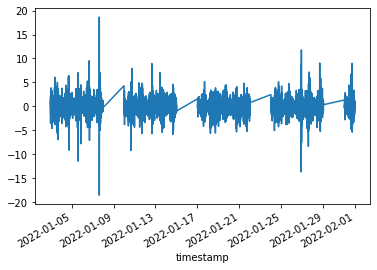

In [212]:
df_merged['pip_value_for_Rs.10000'].plot()

<AxesSubplot:xlabel='timestamp'>

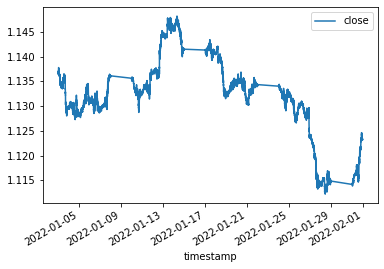

In [213]:
df_merged[['close']].plot()

In [214]:
# df_merged.to_csv("Resources/Trade.csv")

In [216]:
df_merged.shape[0]

30194

In [ ]:
# PIP change values are forecasted with very less accuracy i.e. Conclusion: use time series forecasting to forecast open/close 
# values and news prediction for getting impact of news on pip

# 

# Regression for pip prediction on forex calendar data

In [150]:
# Target = pip value
# feature = currency,description,actual,previous
# index = Datetime

In [209]:
forex = df_merged[['Currency','Description','Actual','Previous','pip_value_for_Rs.10000']]
forex.head()

,Currency,Description,Actual,Previous,pip_value_for_Rs.10000
Datetime,,,,,
2022-01-03 02:32:00,NaN,NaN,NaN,NaN,0.000000
2022-01-03 02:33:00,NaN,NaN,NaN,NaN,0.967680
2022-01-03 02:34:00,NaN,NaN,NaN,NaN,2.111059
2022-01-03 02:35:00,NaN,NaN,NaN,NaN,0.000000
2022-01-03 02:36:00,NaN,NaN,NaN,NaN,-3.519763


In [210]:
forex['Currency'] = forex['Currency'].apply(lambda x: -1 if x=="EUR" else 1)
forex.head()

<ipython-input-210-d7023e5edf8e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forex['Currency'] = forex['Currency'].apply(lambda x: -1 if x=="EUR" else 1)


,Currency,Description,Actual,Previous,pip_value_for_Rs.10000
Datetime,,,,,
2022-01-03 02:32:00,1,NaN,NaN,NaN,0.000000
2022-01-03 02:33:00,1,NaN,NaN,NaN,0.967680
2022-01-03 02:34:00,1,NaN,NaN,NaN,2.111059
2022-01-03 02:35:00,1,NaN,NaN,NaN,0.000000
2022-01-03 02:36:00,1,NaN,NaN,NaN,-3.519763


In [211]:
forex = forex.dropna(0)
# forex[['Actual','Previous']] = forex[['Actual','Previous']].astype(float)
forex.head()

,Currency,Description,Actual,Previous,pip_value_for_Rs.10000
Datetime,,,,,
2022-01-03 13:45:00,-1,Spanish Manufacturing PMI,56.2,57.1,-0.352258
2022-01-03 14:15:00,-1,Italian Manufacturing PMI,62,62.8,-1.233861
2022-01-03 14:20:00,-1,French Final Manufacturing PMI,55.6,54.9,1.849862
2022-01-03 14:25:00,-1,German Final Manufacturing PMI,57.4,57.9,-2.202313
2022-01-03 14:30:00,-1,Final Manufacturing PMI,58,58,2.994302


In [217]:
forex.Description.value_counts()
# insufficient data

Unemployment Claims                   4
Natural Gas Storage                   4
Crude Oil Inventories                 4
Final Services PMI                    2
Final Manufacturing PMI               2
                                     ..
ZEW Economic Sentiment                1
Federal Funds Rate                    1
German Retail Sales m/m               1
Housing Starts                        1
Revised UoM Inflation Expectations    1
Name: Description, Length: 123, dtype: int64

<AxesSubplot:xlabel='Description'>

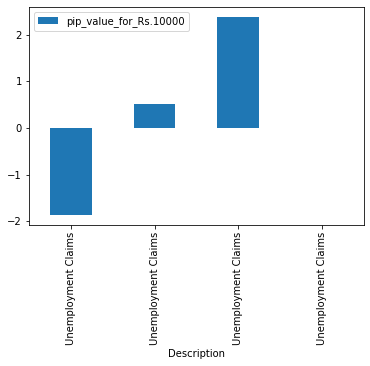

In [218]:
forex[forex['Description']=='Unemployment Claims'].plot.bar(x='Description',y='pip_value_for_Rs.10000')

In [195]:
forex = forex.join(pd.get_dummies(forex['Description']))
forex.head()

,Currency,Description,Actual,Previous,pip_value_for_Rs.10000,ADP Non-Farm Employment Change,Advance GDP Price Index q/q,Advance GDP q/q,Average Hourly Earnings m/m,Belgian NBB Business Climate,...,Spanish Flash GDP q/q,Spanish Manufacturing PMI,Spanish Services PMI,Spanish Unemployment Change,Spanish Unemployment Rate,TIC Long-Term Purchases,Trade Balance,Unemployment Claims,Unemployment Rate,ZEW Economic Sentiment
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-03 13:45:00,-1,Spanish Manufacturing PMI,56.2,57.1,-0.352258,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2022-01-03 14:15:00,-1,Italian Manufacturing PMI,62,62.8,-1.233861,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03 14:20:00,-1,French Final Manufacturing PMI,55.6,54.9,1.849862,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03 14:25:00,-1,German Final Manufacturing PMI,57.4,57.9,-2.202313,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03 14:30:00,-1,Final Manufacturing PMI,58,58,2.994302,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [196]:
Y = forex['pip_value_for_Rs.10000']
X = forex.drop(['Description','pip_value_for_Rs.10000'],1)
X.head()

,Currency,Actual,Previous,ADP Non-Farm Employment Change,Advance GDP Price Index q/q,Advance GDP q/q,Average Hourly Earnings m/m,Belgian NBB Business Climate,Building Permits,Business Inventories m/m,...,Spanish Flash GDP q/q,Spanish Manufacturing PMI,Spanish Services PMI,Spanish Unemployment Change,Spanish Unemployment Rate,TIC Long-Term Purchases,Trade Balance,Unemployment Claims,Unemployment Rate,ZEW Economic Sentiment
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-03 13:45:00,-1,56.2,57.1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2022-01-03 14:15:00,-1,62,62.8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03 14:20:00,-1,55.6,54.9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03 14:25:00,-1,57.4,57.9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03 14:30:00,-1,58,58,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
X_train,Y_train,X_test,Y_test = train_test_split(X,Y,test_size=0.3)

In [198]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [ ]:
lr.fit(X_train,Y_train)

In [ ]:
lr.score(X_test,Y_test)

In [ ]:
lr.predict(X_test)

# NLP sentiment analysis pip prediction to get news impact

In [ ]:
df3= pd.read_csv("train.csv")
df3.head()

In [ ]:
target = df["target"]
data = df.drop("target",1)
data.head()

In [ ]:
target.isna().sum()

In [ ]:
data.nunique()

In [ ]:
data["keyword"].value_counts()

In [ ]:
data["location"].value_counts()

In [ ]:
tweet = data["text"]

# NLP Preprocessing

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.corpus import stopwords
nltk.download('stopwords')
from functools import reduce
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
reviews = data["reviews.text"]
reviews.head()

In [ ]:
reviews = reviews.apply(lambda x: x.lower())

In [ ]:
# /w+ include [a-zA-Z0-9_]
tokenizer = RegexpTokenizer("\w+")
reviews = reviews.apply(lambda x: tokenizer.tokenize(x))
reviews.head()

In [ ]:
reviews = reviews.apply(lambda x: [token.lemma_ for token in nlp(" ".join(x))])
reviews.head()

In [ ]:
Stopwords = stopwords.words("english")
reviews = reviews.apply(lambda x: [word for word in x if word not in Stopwords and len(word)>2])
reviews.head()

In [ ]:
product_reviews = pd.DataFrame()
product_reviews["reviews"] = reviews
product_reviews["product"] = data["name"]
product_reviews.head()

In [ ]:
product_reviews.groupby(["product"],as_index=False).agg({"reviews":sum})
product_reviews.head()

# Wordcloud

In [ ]:
all_tweets = reduce(lambda x,y: x+y, tweets)
wc = WordCloud().generate(" ".join(all_tweets))
plt.imshow(wc)

# Bow Vectorization

In [ ]:
bow_vect = CountVectorizer()
bow_matrix = bow_vect.fit_transform(tweets.apply(lambda x: " ".join(x)))

In [ ]:
bow_matrix.toarray()

In [ ]:
doc_vector = pd.DataFrame(bow_matrix.toarray())

# TF-IDF Vectorization

In [ ]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(reviews.apply(lambda x: " ".join(x)))

In [ ]:
tfidf_scores = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names())
tfidf_scores.head()

# Sentiment Analysis

In [ ]:
df3["reviews"]  = [" ".join(x) for x in reviews]
df3["ratings"] = data["reviews.rating"]

In [ ]:
sia = SentimentIntensityAnalyzer()

df["score"] = df["reviews"].apply(lambda x: sia.polarity_scores(x))
df.head()

In [ ]:
df['label'] = df['score'].apply(lambda x: "neu" if abs(x['compound'])<0.2 else ("neg" if x['compound']<0 else "pos"))

# label or score between 1 to 5 to compare with ratings
df['rate'] = df['score'].apply(lambda x: round((x['compound']+1)*4/2+1))
df.head()

# Test processing

In [ ]:
df_test= pd.read_csv("test.csv")
df_test.head()

In [ ]:
test_target = df["target"]
test_tweet = df["text"]
test_tweet.head()

# NLP Test Preprocessing

In [ ]:
tweets = test_tweet.apply(lambda x: x.lower())
tweets.head()

In [ ]:
tokenizer = RegexpTokenizer("\w+")
tweets = tweets.apply(lambda x: tokenizer.tokenize(x))
tweets.head()

In [ ]:
# lemmatization
tweets = tweets.apply(lambda x: [token.lemma_ for token in nlp(" ".join(x))])
tweets.head()

In [ ]:
Stopwords = stopwords.words("english")
tweets = tweets.apply(lambda x: [word for word in x if word not in Stopwords and len(word)>2])
tweets.head()

# Bow Vectorization

In [ ]:
bow_vect = CountVectorizer()
bow_matrix = bow_vect.fit_transform(tweets.apply(lambda x: " ".join(x)))

In [ ]:
doc_vector = pd.DataFrame(bow_matrix.toarray())

In [ ]:
pred = model.predict(doc_vector)
pred

In [ ]:
pred1 = pd.DataFrame()
pred1["id"] = df_test["id"]
pred1["target"] = pred

In [ ]:
pred1.to_csv("submission.csv", index=False)